# Detecting Microcontroller Behaviour w/ Current Sensing and TinyML

Welcome to this example and tutorial for using TinyML and current sensing to work out what is going on on a target PCB. This example is designed to be a full walkthrough for each stage of the process:
* Setting up the circuits for us to measure current from the target.
* Generating training data for our ML model
* Training the ML Model with TensorFlow and Keras
* Quantizing the ML Model with TensorFlow Lite
* Loading the ML Model onto a microcontroller
* Using the current sensing side channel to determine if an LED is on or off

This work is inspired by prior work I have done, as well as the work of [@stacksmashing](https://twitter.com/stacksmashing) at Level Down security. This work is intended to be a worked Proof of Concept (PoC) for what is the next logical step in these kinds of attacks - using Machine Learning (ML) in current monitoring side-channel analysis attacks. 

**GOAL** - To detect an LED flashing on a target using an TensorFlow Lite ML model running on a different microcontroller speaking to an INA219 power monitor that is reading the power going into the target. 

First we shall setup our environment. We note that TensorFlow **does not support python v3.9.x**, so if you need to, you should run `conda activate` to enable a python 3.8.x environment. We first install TensorFlow and then do our imports...

In [1]:
!python3 -m pip -q install tensorflow 

In [2]:
# TensorFlow is  the open source machine learning library we shall use
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for reproducibility
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

## Can this work? 

Despite prior evidence that says 'yes!' from the work we cited above, there are a few good indicators that this should work. If we setup the INA219 with the Nano 33 Sense and just monitor the Nano target running `blink`, we can see the following output when we use Arduino IDE's Serial Plotter (using the `get_current_data.ino` code for thsoe who want to play along at home):

![initial motivation](media/currentsense-ML-init.png)

We can see clearly when the LED is on - _hint_, it's when there's more power being used! This is only a difference of a few mA (the scale is roughly 10uA per y-increase of 1 in the graph). We also see a lot of noise in the output - where the current reading from the INA219 drops to zero in some position of the 16 numbers we are getting in the output. 

Machine Learning is pretty good at dealing with noise - in fact, it's a _de facto_ selling point of the tech. So in theory, this should have a good chance of working, we just need the following things:
1. A good set of training data...
1. The model to be trained!
1. To deploy the model to a microcontroller. 

# Setting Up and Getting Training Data

Ok, so we've convinced ourselves that this _should_ work... or _might_ work... or _could_ work... so let's get started! 

## Bill of Materials

This tutorial is designed for the following of materials:
1. INA219 Current Measuring over I2C board
1. Arduino Nano ATMEGA329P target board
1. Arduino Nano 33 Sense ML capable board 
1. USB Cables and Laborkabel
1. A Breadboard is handy
1. Support for your target board and the Arduino Nano 33 Sense board in Arduino IDE
1. The `Adafruit_INA219` library installed in Arduino IDE (using `Manage Libraries...`)

## Generation of Training Data

We want to measure the current going to the target using the INA219, so we'll use the following schematic:

![Schematic of circuit](media/currentsense-ML-schematic.png)

Let's break down what is going on here - the Arduino Nano Sense is the main event, providing power for the target and INA219 board from the USB We're powering the target from the Arduino Nano Sense via the sense screw terminal on the INA219 breakout board I'm using. 

The target is an Arduino Nano clone (using the cheap ones as targets as, well, they might break!). This is going to run the default `blink` example code.

The eventual setup I have looks like this:

![photo of setup](media/currentsense-ML-photo.jpeg)

We can now collect some data! So how are we going to do this? Well, here is the rough plan of action:
1. Setup a data collection firmware on the Nano 33 Sense.
1. Setup two target firmwares:
  1. One for the LED being on - `LED_on.ino`
  1. One for the LED being off - `LED_off.ino`
1. Gather training data for each - at least 5k samples.
1. Manipulate the data to make it suitable for TensorFlow. 

## Target Code Snippets

First up, load the `LED_off.ino` example to the target, and the `get_current_data.ino` to the Nano 33 Sense using the Arduino IDE for both (it's a bit of a pain, but if we do this right, we only have to do it a few times! :-P )

Let's look at what each of these does. `LED_off.ino` is the following code: 
```c
void setup() {
  pinMode(LED_BUILTIN, OUTPUT);
}

void loop() {
  digitalWrite(LED_BUILTIN, LOW);
  delay(1000);  
}
```

This code is fairly standard - it just turns the LED on, and monitoring the current from this will generate our 'LED is ON' trainig data from the `get_current_data.ino` firmware. 

**But why the `delay(1000);`?** - Well, my reasoning is as follows; the target code is going to be blinking the LED using the same delay function. We know from the work and products such as the ChipWhisperer from [NewAE](https://www.newae.com/) that current sensing is a very accurate side channel. Although we aren't going to be going 'full tilt' analysis on this target, just having the uC loop without the delay loop might give us some different behaviour (you can try it out to see if this is the case!!). So, in the interest of giving a reasonable example of "how to generate training data", I've included it here. 

We likewise use similar code for getting an 'LED is on' training set:

```c
void setup() {
  pinMode(LED_BUILTIN, OUTPUT);
}

void loop() {
  digitalWrite(LED_BUILTIN, HIGH);
  delay(1000);  
}
```

This code isn't really all that exciting, though... what we really want to look at is the code to...

## Get Current Measurement Training Data

So let's look at the code that analyses the current using the INA219! We'll go through this section by section...

First up is this, well, _dirty hack_... 

```c
// Dirrrrty Haxx...
#define private public
#define protected public
```
Yeah, just so it is said, **NEVER EVER DO THIS IN PRODUCTION** because that would just be _BAD_... But there is a reason for my madness here: I'm a lazy hacker. 

We will be using the `Adafruit_INA219` library (which you can install using the `Manage Libraries...` dialogue in the Arduino IDE). However, I want to access the raw `int16` output from the I2C bus from the INA219 chip. There _is_ a method in the Adafruit library for this; `Adafruit_INA219.getCurrent_raw()` - but this is a `private` method that is inaccessible in normal usage. 

Now, I _could_ write a load of I2C code, which I've done before, that would implement the I2C commands to the INA219 chip based [on the datasheet](https://www.ti.com/lit/ds/symlink/ina219.pdf?ts=1615929778308&ref_url=https%253A%252F%252Fwww.google.com%252F). That would be kinda fun as an exercise, but Adafruit have done the hard work for me, I just need to expose the method so I can use it... 

Thus, writing one line `#define private public` to override the class definition is much easier than writing >100 lines of I2C handler code. Like I said... _lazy hacker_... **DO NOT LET INTO PRODUCTION!**

The next bit is fairly sedentry setup stuff:
```c
#include <Wire.h>
#include <Adafruit_INA219.h>

Adafruit_INA219 ina219;

int16_t curr_array[16];
int i;

void setup(void) 
{
  Serial.begin(115200);
  while (!Serial) {
      // will pause Zero, Leonardo, etc until serial console opens
      delay(1);
  }

  uint32_t currentFrequency;
    
  Serial.println("Hello!");

  if (! ina219.begin()) {
    Serial.println("Failed to find INA219 chip");
    while (1) { delay(10); }
  }
  // To use a slightly lower 32V, 1A range (higher precision on amps):
  //ina219.setCalibration_32V_1A();
  // Or to use a lower 16V, 400mA range (higher precision on volts and amps):
  //ina219.setCalibration_16V_400mA();

  Serial.println("Measuring voltage and current with INA219 ...");
}
```
Nothing really exciting there. We start the UART `Serial` handler, and initialise the INA219. All good! Now we get to the loop:
```c
void loop(void) 
{

  for(i=0;i<16;i++){
    curr_array[i] = ina219.getCurrent_raw();
  }

  Serial.print("[");
  for(i=0; i<15; i++){
    Serial.print(curr_array[i]);
    Serial.print(",");
  }
  Serial.print(curr_array[15]);
  Serial.println("]");
}
```

So let's break this down - Let's start with the acquisition loop:
```c
  for(i=0;i<16;i++){
    curr_array[i] = ina219.getCurrent_raw();
  }
```
This loop gathers data from the INA219. It's kinda important that this is _always done the same way_! If we change this out, by, say, just outputting the bytes once per loop, then if we change the way we do things later, with different length loops on differently clocked microcontrollers, then we will have problems. So this is how we will acquire the data later on when we use the ML model for inference. 

The next block of code is the data output:
```c
  Serial.print("[");
  for(i=0; i<15; i++){
    Serial.print(curr_array[i]);
    Serial.print(",");
  }
  Serial.print(curr_array[15]);
  Serial.println("]");
```
This code outputs something along the lines of:
`[125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125]`
**But why the square brackets?** Well, again, this is me being lazy. If we take a string output like the above, then we can just run in python:
```python
data_str = "[125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125]"
data = eval(data_str)
```
...and we will have a nice python array of numbers ready to go :) We can then load this easily into 

With this code ready, let's carry out our data acquisition plan!


## Training Data Acquisition

Doesn't that all sound so _fancy_?!? It's just us using the code we've discussed above and putting the data into files. So here's the plan:
1. Load the `get_current_data.ino` firmware onto the Arduino Nano 33 Sense. 
1. Load `LED_off.ino` onto the target
1. Power the circuit and run the following command (for linux or sim): `sudo screen -L -Logfile led-off.log /dev/ttyACM0 9600`
1. When you have over 5k lines from this, power off the circuit
1. Load `LED_on.ino` onto the target
1. Power the circuit as before and run: `sudo screen -L -Logfile led-on.log /dev/ttyACM0 9600`
1. Have a cuppa...

We now have our data for 'LED is ON' and 'LED is OFF'! So let's begin the next step.

# Training the TensorFlow Model

Well, now we have data (we've included copies of our own here), we will now setup and train our machine learning model using TensorFlow. First up, some utility functions...

In [3]:
# Copied from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# This will convert our file of [1..16] strings to python lists to a numpy array that is TF friendly...
def file_to_np(filename):
    with open(filename, 'r') as f:
        f_lines = f.readlines()
    f_list = list(map(eval, f_lines))
    f_np = np.array([np.array(fi) for fi in f_list])
    return f_np

## Loading the Data

Next up, we will load the data into some variable arrays that we will use for training in the next step:

In [4]:
e_pochs = 1500

num_samples = 5000
train_size = int(num_samples * 0.6)
test_size = int(num_samples * 0.2)
validate_size = int(num_samples * 0.2) # we let model.fit() do this for us... just define this for now. -MC

# Load the data files... EDIT for your own data! -MC
f_ledoff = file_to_np('example_data/led-off2.log')[:num_samples]
f_ledon = file_to_np('example_data/led-on2.log')[:num_samples]

# Setup the training data...
train_data = []
training_data = []
training_labels = []
train_data.append(f_ledoff[:train_size])
train_data.append(f_ledon[:train_size])
for i in range(2):
    for j in range(train_size):
        training_labels.append(i)
        training_data.append(train_data[i][j])

training_data = np.array(training_data)
training_labels = np.array(training_labels)

# Set aside the test data - this will be used after training to see how we did...
t_data = []
test_data = []
test_labels = []
t_data.append(f_ledoff[train_size:(num_samples - validate_size)])
t_data.append(f_ledon[train_size:(num_samples - validate_size)])
for i in range(2):
    for j in range(test_size):
        test_labels.append(i)
        test_data.append(t_data[i][j])

test_data = np.array(test_data)
test_labels = np.array(test_labels)

# We can also add valdiation data - used to assess the model's efficacy during training,
# but we don't use that here, as we let model.fit() do that for us.. but we _could_ define it ... -MC
#v_data = []
#validate_data = []
#validate_labels = []
#v_data.append(f_ledoff[validate_size:])
#v_data.append(f_ledon[validate_size:])
#for i in range(2):
#    for j in range(validate_size):
#        validate_labels.append(i)
#        validate_data.append(v_data[i][j])
#        
#validate_data = np.array(validate_data)
#validate_labels = np.array(validate_labels)


# Shuffle the data sets so it isn't just 'all 1's then all 0's'...
# This will help with the training, as our data is all linear for now
training_data, training_labels = unison_shuffled_copies(training_data, training_labels)
test_data, test_labels = unison_shuffled_copies(test_data, test_labels)
#validate_data, validate_test = unison_shuffled_copies(validate_data, validate_labels)

So what have we done here? Well, we've built two lists for each dataset - a list of `_data` which are the arrays we got from the microcontroller, and an array of `_labels` which are just `0` if the data came from the `led_off.log` dataset, and `1` if it came from the `led_on.log` dataset. We then shuffle them concurrently to mix up the data for training. 

## Creating the TF Model

So, with that done, let's build a model... 

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(16,)),
    keras.layers.Dense(64, activation=tf.nn.relu), #started at 128, but we don't need that many -MC
    keras.layers.Dense(2, activation=tf.nn.softmax) # output '0' or '1' for LED off or on respectively -MC
])

In [6]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lets save our current model state so we can reload it loater
model.save_weights("model_data/pre-fit.weights")

Let's walk through this a little; the first layer is a flattened 16 number input to the model. There is a single hidden layer of size 64, with an output layer of size 2. The output layer will activate one node for 'LED is OFF' and the other for 'LED is ON', given by the fact we have two labels in our training data. 

The Netron diagram for this model is the following:

![Netron TF diagram](media/LED_model.png)

This model is _incredibly basic_ and yes, there are many, many improvements that can be made. But honestly? This is Proof of Concept (PoC) code! This is just to see if we can make it work, in any sense, without any refinements. So, we're just gonna leave that there and get on with training! 

## Training the model

The training function in TensorFlow is `model.fit()` which takes our training data and training labels, determines the validation split 

In [7]:
history = model.fit(training_data, training_labels, epochs=e_pochs, validation_split=0.2, verbose=0)

Let's see how we did! We'll draw a graph detailing the loss (the penalty for the model making a bad prediction - basically, how much we had to tell the model off for getting it wrong) and accuracy (how accurate our model was) by looking at the data generated about it during training:

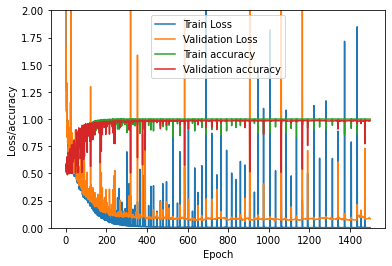

In [8]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/accuracy')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Validation Loss')
    plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Train accuracy')
    plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Validation accuracy')
    plt.legend()
    plt.ylim([0, 2])

plot_history(history)

In [9]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Accuracy on testdata:', test_acc * 100, "%")

63/63 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9735
Accuracy on testdata: 97.35000133514404 %


The last cell loads the accuracy as a percentage overall... For the training data I have it's at 97% _and that ain't at all bad!_ Without any real work or jiggery-pokery, we have managed to get a model to 97% accuracy! Ace! 

## Refinements

In short, not yet. This PoC is to focus on getting the model into a microcontroller, rather than building a perfect model... As such, 97% is more than good enough for our purposes, so let's get on with loading this onto the microcontroller!

# Model Deployment on a Microcontroller

First off, let's convert our TF model to a TF Lite model, making it nice and small. 

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model_data/LED_model.tflite", 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp71hulek1/assets


6524

## Model Quantisation

Now, whilst the TF Lite model is, well, much lighter, it's still a bit big... As every machine learning engineer comes to ask, _"does my model look big in this?"_

Even though our model _isn't actually that big_, you may want to develop a much more nuanced model, or a model with more layers or more inputs from bigger training sets, etc. etc. So we're going to assume that we want/need to quantise our TFLite model to make it fit onto a microcontroller. 

Here's the code we are using - we'll run through it after the break:

In [11]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Indicate that we want to perform the default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
def representative_dataset_generator():
    for value in test_data:
        # Each scalar value must be inside of a 2D array that is wrapped in a list
        yield [np.array(value, dtype=np.float32, ndmin=2)]

converter.representative_dataset = representative_dataset_generator
# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("model_data/LED_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9rb03mbh/assets


INFO:tensorflow:Assets written to: /tmp/tmp9rb03mbh/assets


3936

## What is a quantised model?

Here is the Netron diagram for the resultant quantised model:

![quantised model diagram](media/LED_model_quantized.png)

You'll notice - _it's exactly the same as the other one_ except for the addition of the `quantise`/`dequantise` steps at the top/tail respectively. So what is going on? Well, we're essentially converting the model from the bold, `float32` inspired world of "I have a CISC CPU and a power supply measured in tens-to-hundreds of Watts" down to something that, essentially, can be powered by a potato or two (well, more likely a few dozen lemons... they have more potential energy)

To do this, the model is reconfigured to use `int8` as its base - yes, you read that right. That makes it monumentally more friendly to data types on microcontrollers... but surely we have to do something to our input data? And, well, you're right. 

Fundamentally, our model has been squeezed, so we need to squeeze the inputs/outputs a little to recover the original state of the model. The actual [TensorFlow int8 quantised model specification](https://www.tensorflow.org/lite/performance/quantization_spec) details the specifics, but the most important part is the way in which the inputs are scaled:

![equation](http://www.sciweavers.org/tex2img.php?eq=real%5C_val%20%3D%20%28int8%5C_val%20-%20zero%5C_point%29%20%5Ctimes%20scale&bc=White&fc=Black&im=jpg&fs=12&ff=arev&edit=)

Which yields the following calculation for our inputs:

![equation 2](http://www.sciweavers.org/tex2img.php?eq=int8%5C_val%20%3D%20%28real%5C_val%20%20%2F%20%20scale%20%29%20%2B%20zero%5C_point&bc=White&fc=Black&im=jpg&fs=12&ff=arev&edit=)

Let's first process the model and make it ready...

In [12]:
!xxd -i model_data/LED_model_quantized.tflite > model_data/LED_model_quantized.cc
!head -n 10 model_data/LED_model_quantized.cc && echo "..." && tail -n 10 model_data/LED_model_quantized.cc

unsigned char model_data_LED_model_quantized_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x12, 0x00, 0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0xc0, 0x0e, 0x00, 0x00, 0x04, 0x07, 0x00, 0x00,
  0xec, 0x06, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x0b, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
...
  0xd4, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x06, 0x02, 0x00, 0x00, 0x00,
  0x06, 0x00, 0x00, 0x00, 0xc8, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x72,
  0x72, 0x00, 0x00, 0x00, 0xf0, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x19,
  0x02, 0x00, 0x00, 0x00, 0x19, 0x00, 0x00, 0x00, 

## Loading the Model into the Arduino

We're now ready to load the model onto the Arduino Nano 33 Sense! 

### Overview of the project files

So now that we have our `LED_model_quantized.cc`, let's look at how to load this. First up, here's a quick overview of the files in the `Arduino_CurrentSense_ML` directory:

* `arduino_constants.cpp` - Some constants used in the project.
* `arduino_main.cpp` - The `setup()` and `loop()` functions used by Arduino IDE
* `arduino_output_handler.cpp` - The output handler for the output from the model inference.
* `constants.h` - More constants.
* `current_ML.ino` - the main project file! Sets up the model, loads the data, passes the output to the `output_handler`.
* `main_functions.h` - main function headers
* `model.cpp` - the model itself! Copied from `LED_model_quantized.cc`
* `model.h` - model header definitions
* `output_handler.h` - output handler header definitions.

If you haven't already, copy the model details, the array and size variable, from `LED_model_quantized.cc` into `model.cpp`, ensuring to fix the variable names in `current_ML.ino` if required.

### Walking through the Firmware Code

We won't go through the whole of the code in the project, but will outline the main part! 

The `setup()` function in `current_ML.ino` is almost identical to the `hello_world` TFLite example code - it loads the model as `g_model`, finds the input/output tensors, stores their addresses, etc. etc. It also setups up the INA219 device, and yes, employs my _dirrrrty hack_ from earlier :P 

We have some other functions to load the data - `load_data()` function is our loader:

```c
void load_data(const int8_t * data, TfLiteTensor * input)
{
    for (int i = 0; i < 16; ++i)
    {
        input->data.int8[i] = data[i];
    }
}
```
In the main `loop()` we have the same function loop as we did before, but this time adjusting based on the pre-loaded scale and zero point that TF Lite calculated for us when we quantized the model. These are stored in `input->params.scale` and `input->params.zero_point` respectively.
```c    
int param;
for(i=0;i < 16; i += 1){
    param = ina219.getCurrent_raw();
    // scale the input...
    curr_array[i] = param / input->params.scale + input->params.zero_point;
}
load_data(curr_array, input);
```

We run the model on the input tensor we have setup by running `TfLiteStatus invoke_status = interpreter->Invoke();`, and if there are no errors, we then get the outputs from the inference (which are `float32`) and pass these to `HandleOutput`:
```c
float y_1 = output->data.f[0]; // get last byte of output...
float y_2 = output->data.f[1];
HandleOutput(error_reporter, y_1, y_2);
```

From here, we process these outputs as follows:
```c
void HandleOutput(tflite::ErrorReporter* error_reporter, float x_1, float x_2) {
  // Do this only once
  if (!initialized) {
    // Set the LED pin to output
    pinMode(led, OUTPUT);
    initialized = true;
  }

  bool output = (x_2 == 0) ? LOW : HIGH; // we'll just use x_2, but can add for x_1 as well... 
  digitalWrite(led, output);

  // Log the current brightness value for display in the Arduino plotter
  TF_LITE_REPORT_ERROR(error_reporter, "LED guess: %d\n", output);
}
```

# Conclusions

Well, in case you missed it, it works! It's flaky as anything, as seen by the intermitten blinking, but it does work! Here's a PoC GIF for the curious:

![PoC](media/proof_of_concept.gif)

## Known Issues

So, there are some things I have noticed whilst playing with this model and deploying it. We'll take this as a 'things you can try to fix for yourself' (the lab has some WIP fixes for this and other projects on the way).

**1** Sometimes, the model inverts - it will activate on the LED being OFF, and never activate on being ON. Moving the target around actually seems to affect this, so my guess is there is some response to parasitic capacitance. The fix is likely - use shorter power leads to the target!

**2** The code needs a lot of reworking - there are many areas where speed can be improved or things can be done better. Feel free to make a PR!

## Why an INA219?

It's probably natural to ask _But why an INA219? Why not an ADC that's built in?!?_ If you've played around with electronics, you've probably built a current monitor with a microcontroller, and might think that the INA219 is misplaced or overkill to use one... Well, there are a few reasons we consider for using the INA219. 

First up, I didn't want to have to start adding requirements for a solid `AREF` for a start - yes, you can get low-dropout regulators like the `LM2937` or similar, and yes, these would do the job, but it's more parts, more things to setup, and it could complicate the setup.

Second reason is that of specialisation - the INA219 is specifically designed for this task! And the breakout boards are inexpensive, easy to come by, and readily available. Yes, the ADCs are already there, but they would require extra work to meet the requriements for the things the INA219 already does. 

Lastly, that of portability - in theory, using a part that communicates in I2C means that you don't _need_ an Arduino Nano 33 Sense to make this project work! In theory, you can plug in any microcontroller, re-run the training code, recompile and redeploy in short order; all without having to worry about ADC specifics for a different microcontroller.

## Future Work

This idea can easily be extended to other sensors and for other target types! We wanted to show that a roughly 2mA difference in operation could still be identifiable without any major reworking of PCBs or parts, effectively running this off the shelf. This design could be quickly extended to monitor USB current, Hall Effect sensors, or other unusual situations where a TinyML model could do something useful or cool! 

Thanks for the attention, and Happy Hacking!